# Heart Failure Final Report


In [2]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.12.4 (v3.12.4:8e8a4baf65, Jun  6 2024, 17:33:18) [Clang 13.0.0 (clang-1300.0.29.30)]


In [ ]:
import pandas as pd; print(f"pandas version {pd.__version__}")
import numpy as np; print(f"numpy version {np.__version__}")
import sklearn as sk; print(f"sci-kit learn version {sk.__version__}")
import seaborn as sns; print(f"seaborn version {sns.__version__}")

pandas version 2.2.2
numpy version 1.26.4
sci-kit learn version 1.6.1
seaborn version 0.13.2


In [4]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data loading
csv_path = 'heart_failure_clinical_records_dataset 2.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f'Loaded local CSV: {csv_path} ({df.shape[0]} rows, {df.shape[1]} columns)')
else:
    try:
        from ucimlrepo import fetch_ucirepo
        heart_failure_clinical_records = fetch_ucirepo(id=519)
        X = heart_failure_clinical_records.data.features
        y = heart_failure_clinical_records.data.targets
        df = pd.concat([X, y], axis=1)
        print('Fetched dataset via ucimlrepo (id=519).')
        print(f'Dataset shape: {df.shape}')
    except ModuleNotFoundError:
        raise ModuleNotFoundError('ucimlrepo is not installed please install ucimlrepo or place the CSV in the notebook directory.')
    
# data explore
print("Missing values:", df.isna().sum().sum())
print("Duplicate rows:", df.duplicated().sum())

display(df.head())


Loaded local CSV: heart_failure_clinical_records_dataset 2.csv (299 rows, 13 columns)
Missing values: 0
Duplicate rows: 0


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Data Analysis

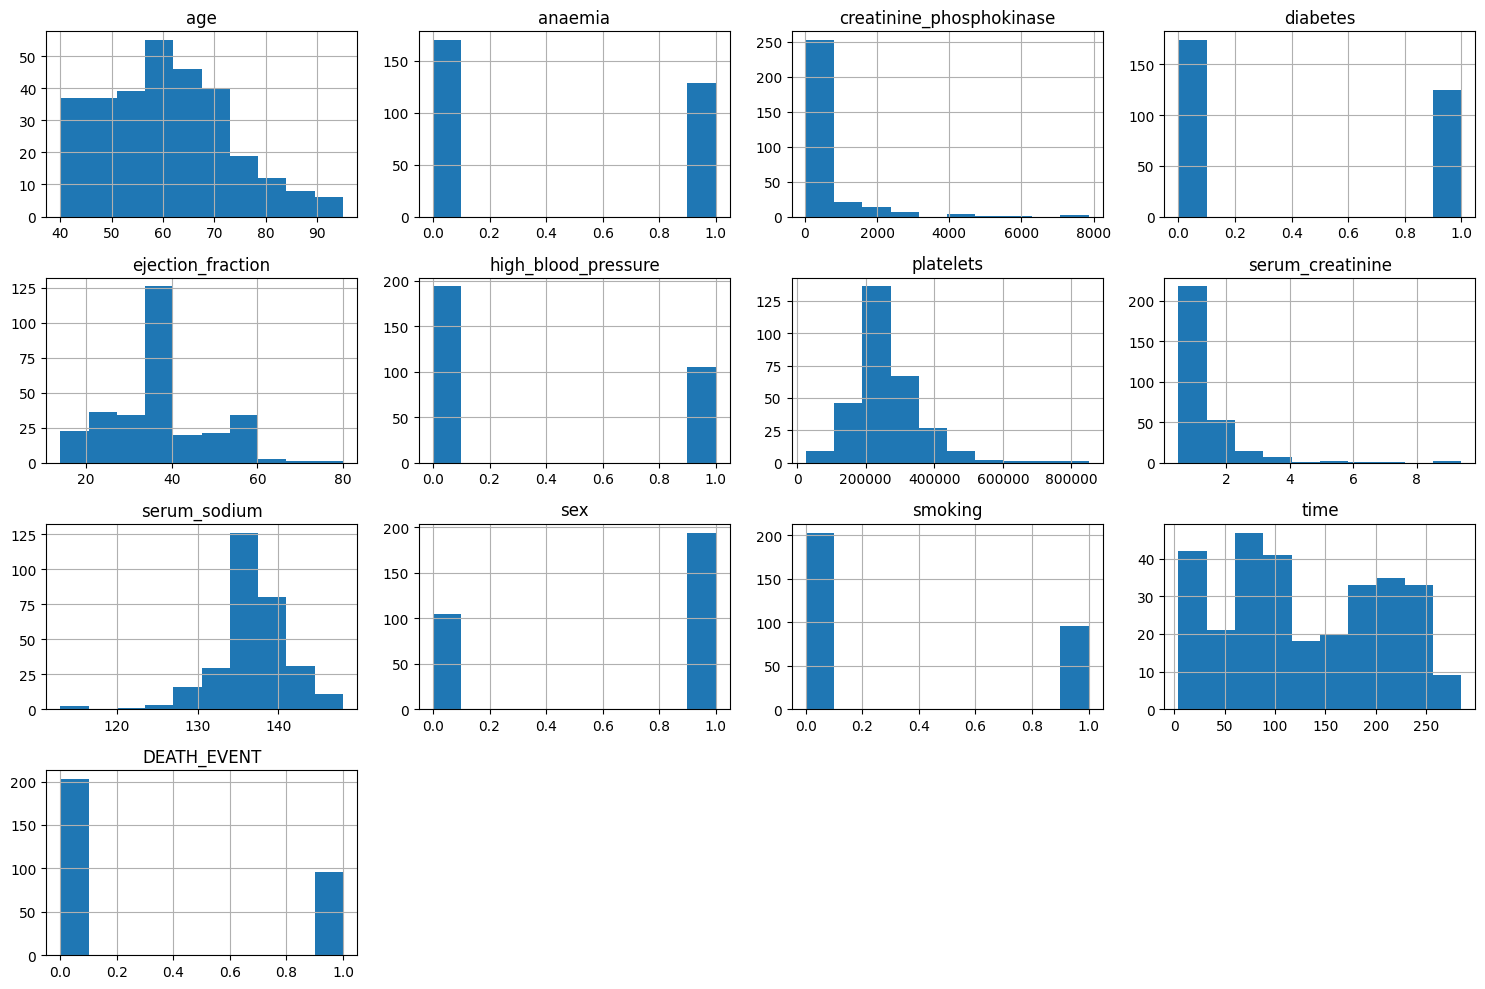

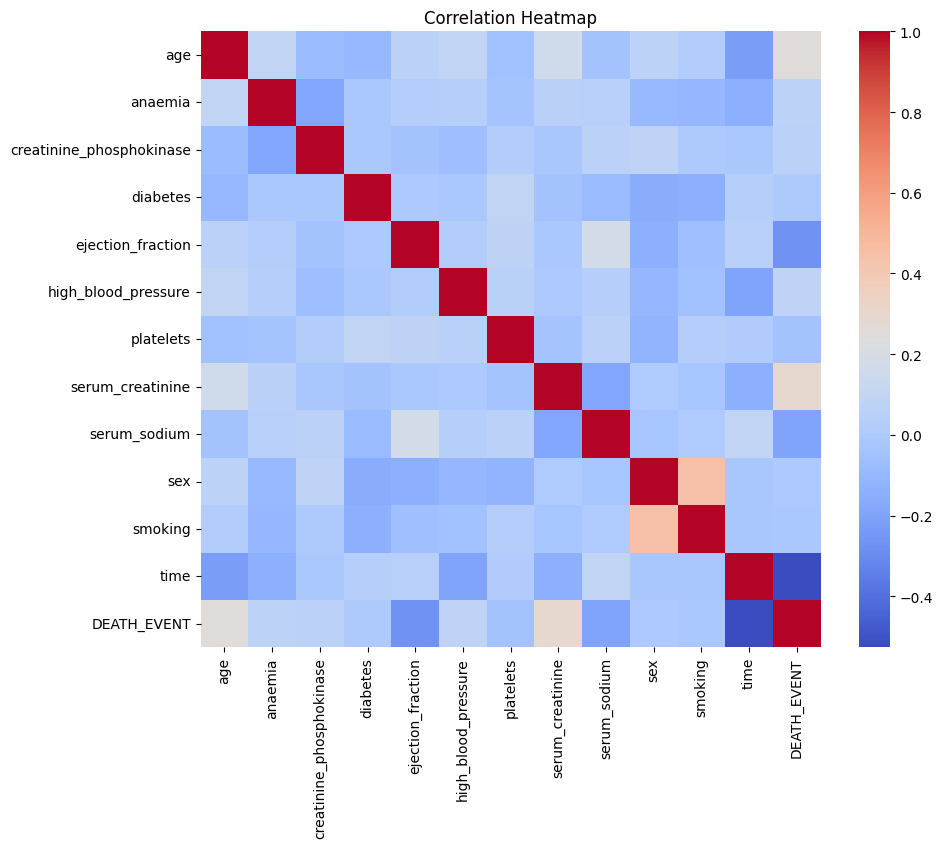

<Figure size 640x480 with 0 Axes>

In [5]:

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(figsize=(15,10))
plt.tight_layout()
plt.show()

#heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()
plt.savefig('correlation_heatmap.png', dpi=300)

## Modeling Approach
Two classifiers evaluated:
 - **Logistic Regression**
 - **Random Forest**

Metric: **ROC‑AUC** with 5‑fold stratified cross‑validation.

logistic regression roc‑auc: 0.875 ± 0.032
random forest       roc‑auc: 0.899 ± 0.026
              precision    recall  f1-score   support

           0      0.830     0.951     0.886        41
           1      0.846     0.579     0.688        19

    accuracy                          0.833        60
   macro avg      0.838     0.765     0.787        60
weighted avg      0.835     0.833     0.823        60

hold‑out roc‑auc = 0.889


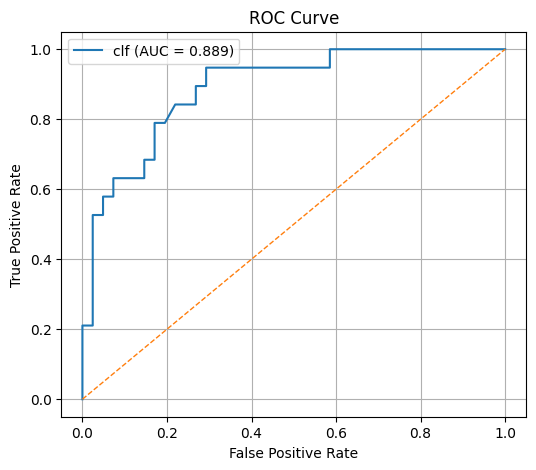

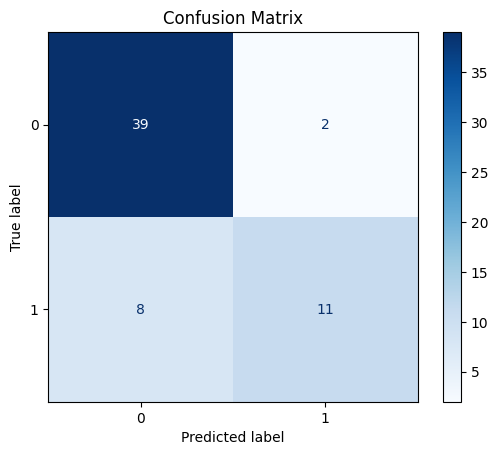

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# split features and target
target = 'DEATH_EVENT'
X = df.drop(columns=[target])
y = df[target]

# preprocessing transformer
numeric_cols     = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', 'passthrough', categorical_cols)
])

# model pipelines
log_reg = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
])
rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=250, random_state=42))
])

# cross-validation to compare models
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_auc = cross_val_score(log_reg, X, y, cv=cv, scoring='roc_auc')
rf_auc  = cross_val_score(rf,     X, y, cv=cv, scoring='roc_auc')

print(f'logistic regression roc‑auc: {log_auc.mean():.3f} ± {log_auc.std():.3f}')
print(f'random forest       roc‑auc: {rf_auc.mean():.3f} ± {rf_auc.std():.3f}')

# hold-out train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
best_model = log_reg if log_auc.mean() >= rf_auc.mean() else rf

# train and predict
best_model.fit(X_train, y_train)
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

# final evaluation
print(classification_report(y_test, y_pred, digits=3))
print(f'hold‑out roc‑auc = {roc_auc_score(y_test, y_proba):.3f}')

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'{best_model.steps[-1][0]} (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# confusion matrix plot
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
